# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from scipy import stats
from sklearn import metrics
import glob
import csv
import os
%matplotlib inline
from keras_self_attention import SeqSelfAttention
import warnings
warnings.filterwarnings('ignore')

# Check if GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
    
interesting_dir = "./Data/Fastest/"
#interesting_files = ["sit.csv", "stand.csv", "walk.csv"]
interesting_labels = ['stand', 'walk','jump','fall']
save_filename = "activity"

Using TensorFlow backend.


Default GPU Device: /device:GPU:0


# Concate and label the raw data  

In [2]:
def data_concate_label(path,label):
    all_files1 = glob.glob(path + "/*.csv")
    
    li = []

    for filename in all_files1:
        df = pd.read_csv(filename, index_col=None, header=0)
        
        if 'label' in df.columns:
            pass
        else:df['label'] = str(label)
        li.append(df)
    frame = pd.concat(li, axis=0, ignore_index=True)
#     frame = frame.drop_duplicates()
    
    if len(df.columns) == 19 :
        new_header =['DATE','TIME','ax','ay','az','gx','gy','gz','lx','ly','lz','mx','my','mz','ma','mg','ml','mm','label']
    
    else :
       
        new_header =['DATE','TIME','ax','ay','az','gx','gy','gz','ma','mg','label']
#     if label == 'fall':
#         frame = frame.drop_duplicates()
        
#         frame = frame.query("mg >= 10 ")
#     if label =='jump':
        
#         frame = frame.query("mg <= 6")
    
#     else : pass
    frame = frame[:16000]
    
    print(frame.shape)
    print(len(df.columns))
    frame.to_csv("./Data/Fastest/activity_"+str(label)+".csv",index = False,header=new_header)
    

In [3]:
path1 = r".\Data\Fastest\stand"
label1 = "stand"
path2 = r".\Data\Fastest\walk_new"
label2 = "walk"
path3 = r".\Data\Fastest\jump"
label3 = "jump"
path4 = r".\Data\Fastest\Fall"
label4 = "fall"
data_concate_label(path1,label1)
data_concate_label(path2,label2)
data_concate_label(path3,label3)
data_concate_label(path4,label4)

(16000, 11)
11
(16000, 11)
11
(16000, 11)
11
(16000, 11)
11


# Concate all data into one .csv file

In [20]:
import copy

df = pd.DataFrame()
for i in range(len(interesting_labels)):
#     df_tmp = pd.read_csv(interesting_dir+save_filename+"_"+str(i+1)+'.csv',parse_dates=[['DATE', ' TIME']],header = 0)
    df_tmp = pd.read_csv(interesting_dir+save_filename+"_"+interesting_labels[i]+'.csv',header = 0)
    df = pd.concat([df, df_tmp])
    
print(len(df.columns))
# df['ts'] = df[['DATE_TIME']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)
# df = df.assign(DATE_TIME=df['ts'])
# if len(df.columns) == 19 :
drop_list = ['DATE','TIME','mg','ma']
# else :pass

# drop_list = ['DATE','TIME','ma','mg']
df = df.drop(drop_list, axis=1)
df = df.dropna()

# df.rename(columns = {'DATE_TIME':'ts'}, inplace = True) 
all_data_filename = "total.csv"
df.to_csv(interesting_dir+all_data_filename)

# df.reset_index(inplace = True) 
df

11


,ax,ay,az,gx,gy,gz,label
0,9.592826,2.708675,0.942772,-0.007327,0.045181,-0.400524,stand
1,9.592826,2.708675,0.942772,-0.050066,0.036633,-0.433494,stand
2,9.463613,2.718246,0.942772,-0.050066,0.036633,-0.433494,stand
3,9.463613,2.718246,0.942772,-0.051287,0.026864,-0.417620,stand
4,9.348758,2.675176,0.978664,-0.051287,0.026864,-0.417620,stand
...,...,...,...,...,...,...,...
15995,-1.533799,0.641277,8.563912,0.768079,-0.536068,0.829134,fall
15996,-1.469193,0.636491,8.702696,0.768079,-0.536068,0.829134,fall
15997,-1.469193,0.636491,8.702696,0.638641,-0.700918,0.799828,fall
15998,-1.227518,0.701097,8.896515,0.638641,-0.700918,0.799828,fall


In [21]:
# normalize

# df[df.columns[:-1]] = df[df.columns[:-1]].apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
# df

# Feature correlation (optional)

In [22]:
# use deepcopy to avoid other operation change value of df
df_cor = copy.deepcopy(df) 

features = df_cor.columns[0:-1]
df_cor["label"] = pd.factorize(df_cor.label)[0]
traindf = pd.DataFrame(df_cor,columns=features)
#print(df_cor["label"])
#print(traindf)

feature_name = list(traindf.columns)
print(feature_name)
y = df_cor['label']
X = traindf.copy()
X.isna().sum()
# X.dropna()
# X.fillna('mean')

['ax', 'ay', 'az', 'gx', 'gy', 'gz']


ax    0
ay    0
az    0
gx    0
gy    0
gz    0
dtype: int64

[0.1868804  0.18223549 0.17120378 0.12547144 0.13894136 0.19526752]


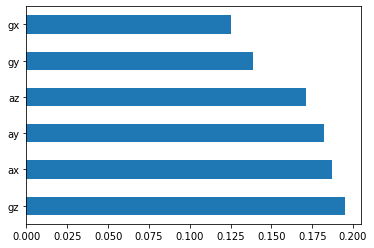

In [161]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

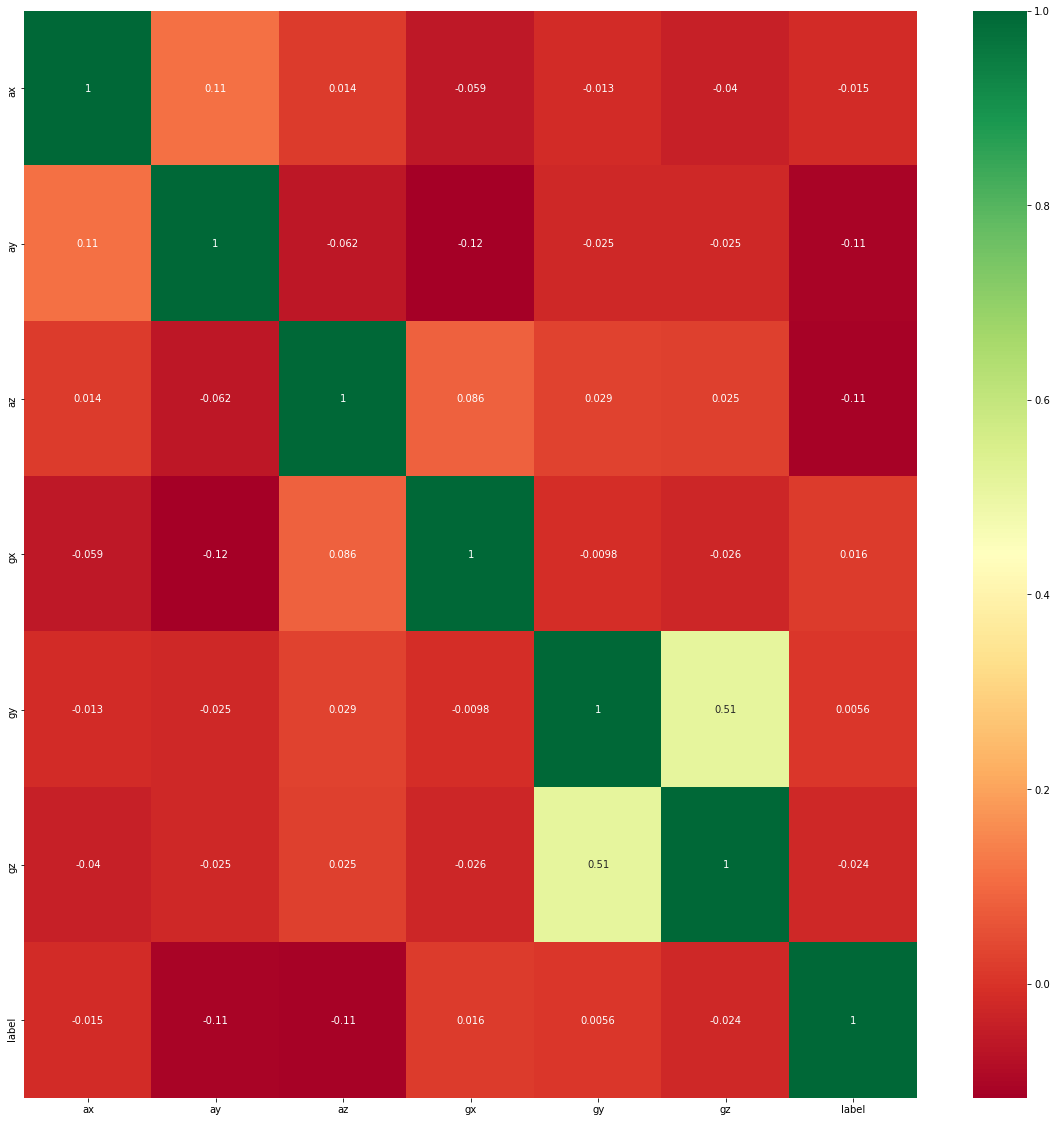

In [162]:
#get correlations of each features in dataset

corrmat = df_cor.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df_cor[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [163]:
num_feats= len(feature_name)
X.columns.tolist()

['ax', 'ay', 'az', 'gx', 'gy', 'gz']

In [164]:
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
        
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
   
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]

    return cor_support, cor_feature, cor_list

cor_support, cor_feature, cor_list = cor_selector(X, y,num_feats)
cor_val=[abs(x) for x in cor_list]
cor_result = dict(zip(cor_feature, cor_val))
myDict = {key:val for key, val in cor_result.items() if val > 0}
{k: v for k, v in sorted(myDict.items(),reverse=True, key=lambda item: item[1])}

{'gx': 0.11074125802579549,
 'ax': 0.10801958019976035,
 'az': 0.02396790664037824,
 'gz': 0.01612804616173598,
 'gy': 0.014635502759461575,
 'ay': 0.005552328447956243}

In [166]:
activities = df_plot['label'].value_counts().index

In [167]:
activities

Index(['stand', 'jump', 'walk', 'fall'], dtype='object')

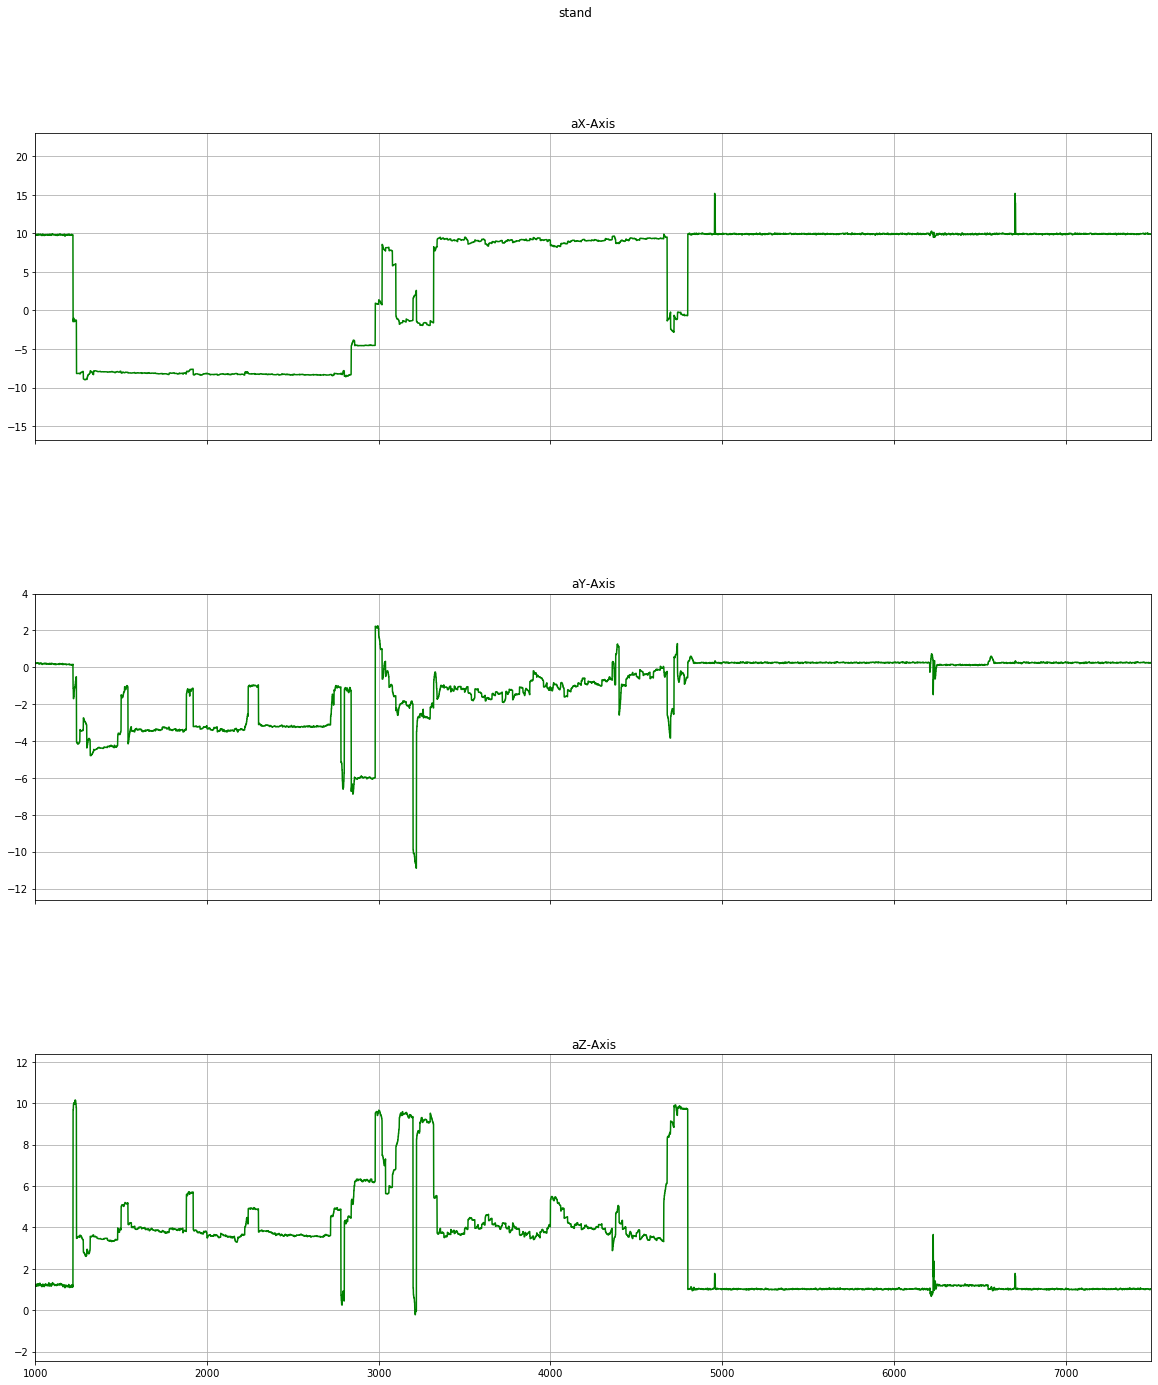

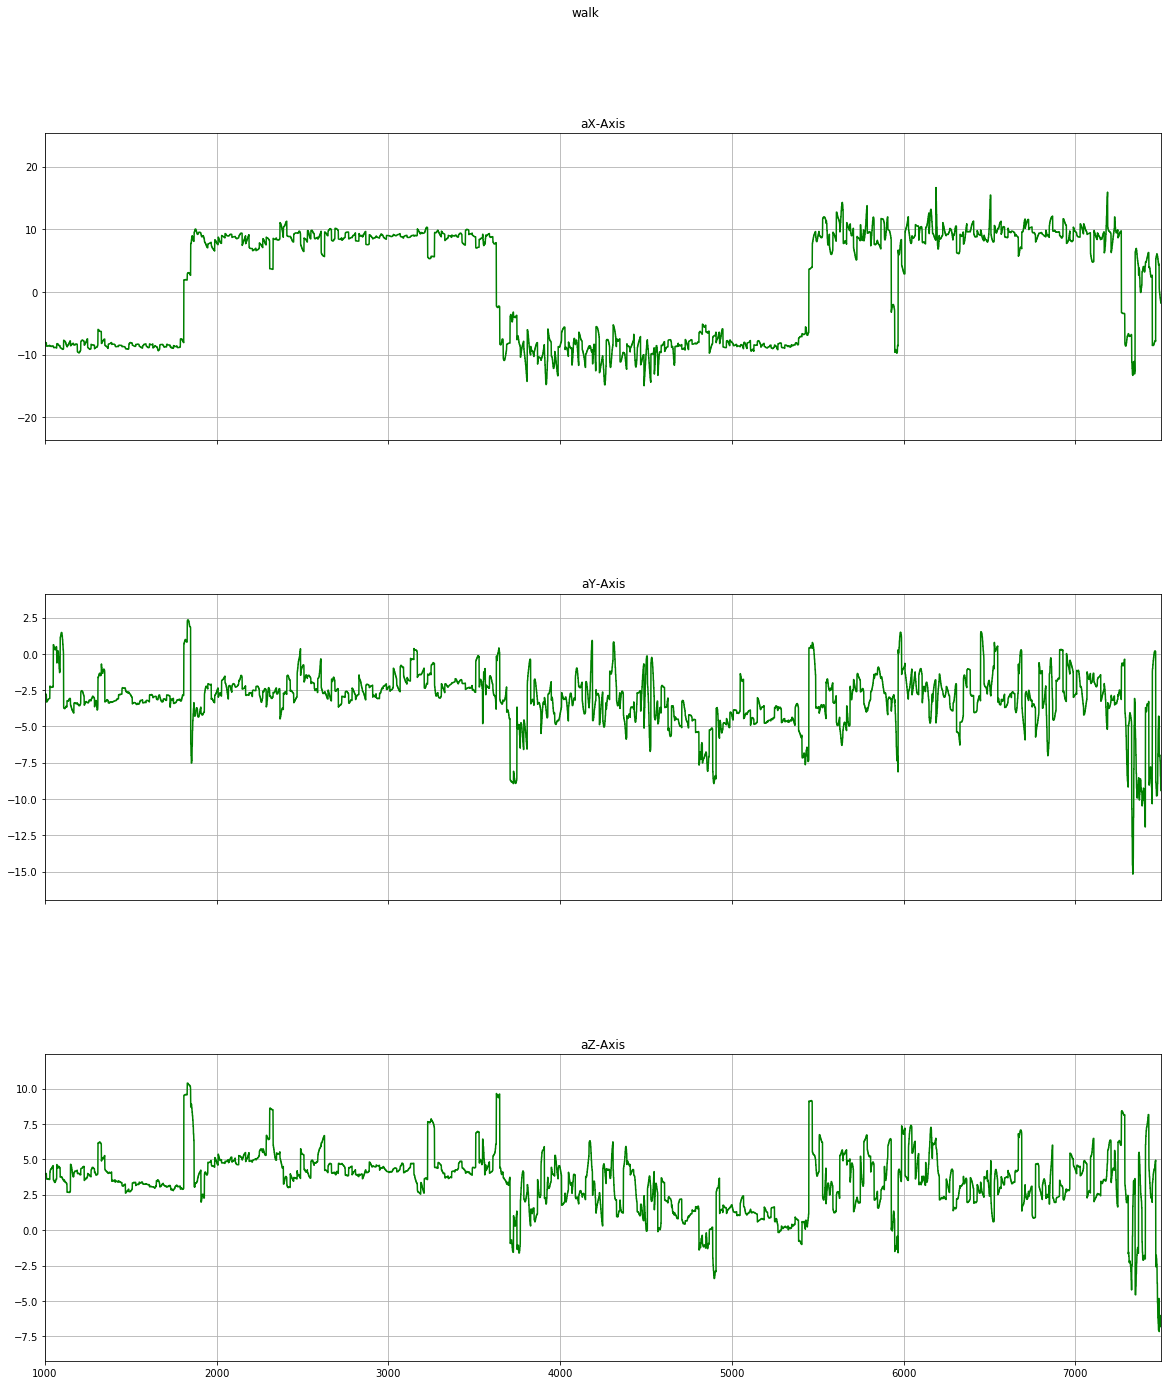

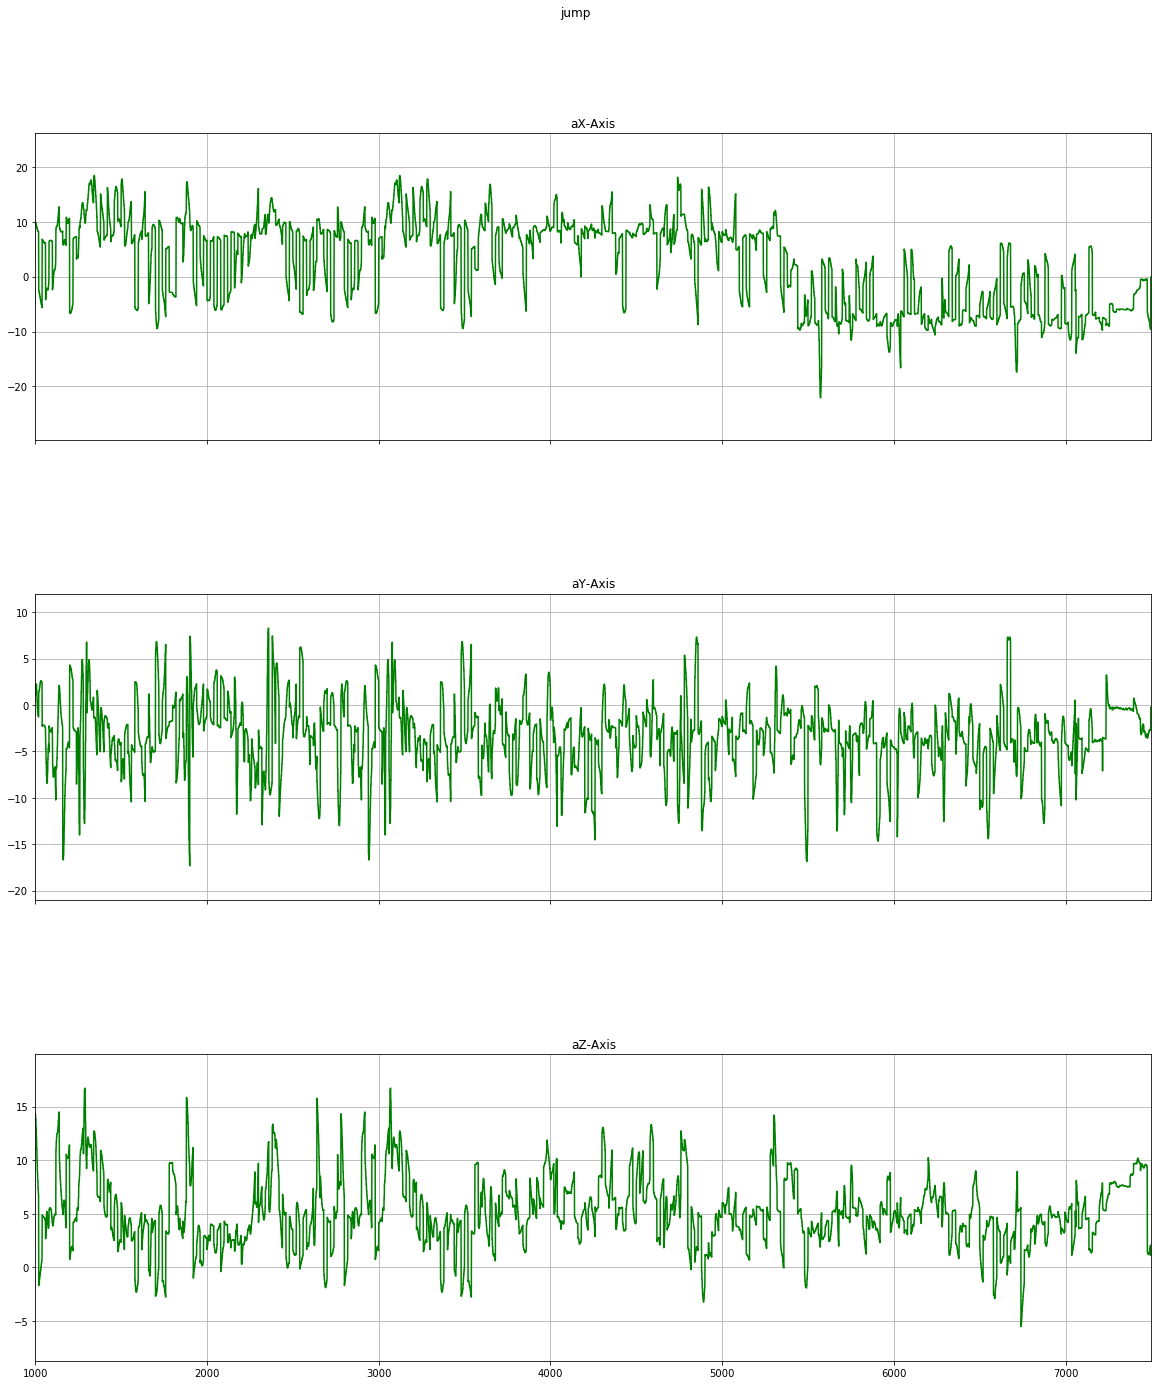

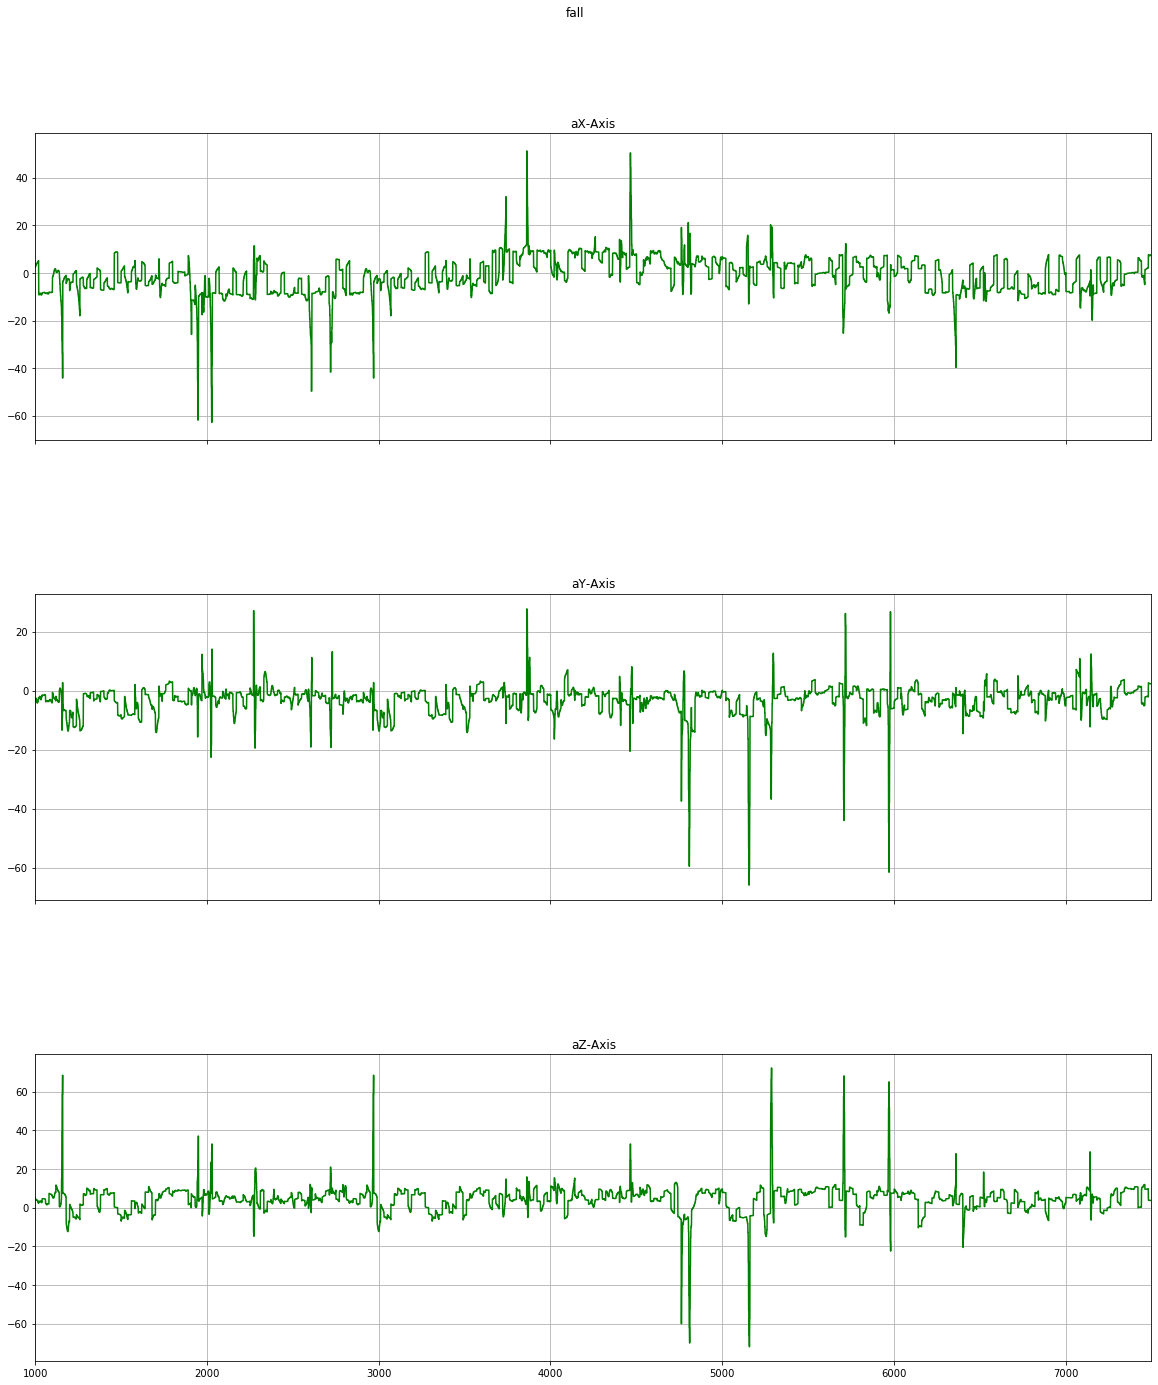

In [17]:
df_plot = copy.deepcopy(df)
df_plot.reset_index(inplace = True) 
activities = df_plot['label'].value_counts().index
def plot_activity(activity, data):
#     fig, (ax0, ax1, ax2,ax3,ax4,ax5) = plt.subplots(nrows=6, figsize=(20, 22), sharex=True)
    fig, (ax0, ax2,ax4) = plt.subplots(nrows=3, figsize=(20, 22), sharex=True)
    plot_axis(ax0, data['index'], data['ax'], 'aX-Axis')
    plot_axis(ax2, data['index'], data['ay'], 'aY-Axis')
    plot_axis(ax4, data['index'], data['az'], 'aZ-Axis')
#     plot_axis(ax1, data['index'], data['gx'], 'gX-Axis')
#     plot_axis(ax3, data['index'], data['gy'], 'gY-Axis')
#     plot_axis(ax5, data['index'], data['gz'], 'gZ-Axis')
    fig.suptitle(activity)
    plt.subplots_adjust(hspace=0.5)
    
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
#     ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
Fs=200
for activity in activities:
    data_for_plot = df_plot[(df_plot['label'] == activity)][1000:7500]
#     print(data_for_plot)
#     print(activity)
    plot_activity(activity, data_for_plot)

# Split training and testing data

In [23]:
def train_test_split(label, ratio):
    split_point = int(len(df[df.label == label]) * ratio)
    return (df[df.label == label].iloc[:split_point, :], df[df.label == label].iloc[split_point:, :])

split_ratio = 0.8
train_data = pd.DataFrame([])
test_data = pd.DataFrame([])

for i in range(len(interesting_labels)):
    (train, test) = train_test_split(interesting_labels[i], split_ratio)
    train_data = pd.concat([train_data, train])
    test_data = pd.concat([test_data, test])

print("Number of train samples: ", len(train_data))
print("Number of test samples: ", len(test_data))


train_label = train_data['label'].to_frame()
test_label = test_data['label'].to_frame()

Number of train samples:  51200
Number of test samples:  12800


# Data Segmentation (Sliding Window)

In [93]:
N_TIME_STEPS = 120 #sliding window length
STEP = 20 #Sliding window step size
N_FEATURES = 6

def generate_sequence(x, y, n_time_steps, step):
    
    segments = []
    labels = []
    for i in range(0, len(x) - n_time_steps, step):
        ax = x['ax'].values[i: i + n_time_steps]
        ay = x['ay'].values[i: i + n_time_steps]
        az = x['az'].values[i: i + n_time_steps]

#         lx = x['lx'].values[i: i + n_time_steps]
#         ly = x['ly'].values[i: i + n_time_steps]
#         lz = x['lz'].values[i: i + n_time_steps]
        gx = x['gx'].values[i: i + n_time_steps]
        gy = x['gy'].values[i: i + n_time_steps]
        gz = x['gz'].values[i: i + n_time_steps]

# #         mx = x['mx'].values[i: i + n_time_steps]
# #         my = x['my'].values[i: i + n_time_steps]
# #         mz = x['mz'].values[i: i + n_time_steps]
        
#         ma =  x['ma'].values[i: i + n_time_steps]
#         mg =  x['mg'].values[i: i + n_time_steps]
#         ml =  x['ml'].values[i: i + n_time_steps]
#         mm =  x['mm'].values[i: i + n_time_steps]
                
       
        label = stats.mode(y['label'][i: i + n_time_steps])[0][0]
#         segments.append([ax, ay, az, gx, gy, gz, lx, ly, lz, mx, my, mz, ma, mg, ml, mm])
#         segments.append([ax, ay, az, gx, gy, gz, mx, my, mz])
        segments.append([ax, ay, az, gx, gy, gz])
        labels.append(label)
        
    return segments, labels

train_X, train_y = generate_sequence(train_data, train_label, N_TIME_STEPS, STEP)
test_X, test_y = generate_sequence(test_data, test_label, N_TIME_STEPS, STEP)

In [94]:
# reshape input segments and one-hot encode labels
def reshape_segments(x, y, n_time_steps, n_features):
    
    x_reshaped = np.asarray(x, dtype= np.float32).reshape(-1, n_time_steps, n_features)
    y_reshaped = np.asarray(pd.get_dummies(y), dtype = np.float32)
    return x_reshaped, y_reshaped

X_train, y_train = reshape_segments(train_X, train_y, N_TIME_STEPS, N_FEATURES)
X_test, y_test = reshape_segments(test_X, test_y, N_TIME_STEPS, N_FEATURES)

In [95]:
y_test

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

# Import DL Library

In [96]:
from keras.regularizers import l2
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Flatten, Bidirectional
from tensorflow.keras.layers import Attention
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras import optimizers
from keras import backend as K
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
N_CLASSES = 4
# N_HIDDEN_UNITS = 8
L2 = 0.00001

# LSTM Model (Training) 

In [98]:
# LSTM model
from keras.backend import clear_session
filepath = 'har_model_lstm_2021.h5'

clear_session()
model = Sequential()
# model.add(LSTM(200, return_sequences=True, input_shape=(N_TIME_STEPS, N_FEATURES), 
#          kernel_initializer='orthogonal', kernel_regularizer=l2(L2), recurrent_regularizer=l2(L2),
#          bias_regularizer=l2(L2), name="LSTM_1"))
# model.add(LSTM(200,return_sequences=True, name="LSTM_2"))
# model.add(Bidirectional(LSTM(200, input_shape=(N_TIME_STEPS, N_FEATURES), 
#          kernel_initializer='orthogonal', kernel_regularizer=l2(L2), recurrent_regularizer=l2(L2),
#          bias_regularizer=l2(L2), name="LSTM_1")))
model.add(Bidirectional(LSTM(200, return_sequences=True,kernel_initializer='orthogonal', kernel_regularizer=l2(L2), recurrent_regularizer=l2(L2),
         bias_regularizer=l2(L2),name="LSTM_1"), input_shape=(N_TIME_STEPS, N_FEATURES)))
# model.add(Bidirectional(LSTM(200, return_sequences=True, name="LSTM_1")))
# model.add(SeqSelfAttention(attention_activation='sigmoid'))

model.add(Flatten(name='Flatten'))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(L2), bias_regularizer=l2(L2), name="Dense_3"))
model.add(Dropout(0.2))
model.add(Dense(N_CLASSES, activation='softmax', kernel_regularizer=l2(L2), bias_regularizer=l2(L2), name="Dense_4"))


model.summary()
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)
stop = EarlyStopping(monitor='val_loss', patience =5,
                      verbose=0, mode='auto', baseline=None, 
                      restore_best_weights=False)
reduce =  ReduceLROnPlateau(monitor='val_loss',
                    factor=0.5,
                    patience=2,
                    verbose=1)
callbacks = [checkpoint,stop]

opt = optimizers.Adam(0.001)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

BATCH_SIZE =64
N_EPOCHS = 300

lstm = model.fit(X_train, y_train,
          batch_size=BATCH_SIZE, shuffle=True,epochs=N_EPOCHS,callbacks=callbacks,
          validation_data=(X_test, y_test))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 120, 400)          331200    
_________________________________________________________________
Flatten (Flatten)            (None, 48000)             0         
_________________________________________________________________
Dense_3 (Dense)              (None, 128)               6144128   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
Dense_4 (Dense)              (None, 4)                 516       
Total params: 6,475,844
Trainable params: 6,475,844
Non-trainable params: 0
_________________________________________________________________
Train on 2554 samples, validate on 634 samples
Epoch 1/300
2554/2554 [==============================] - 8s 3ms

In [59]:
92 0.2288 1 layer lstm 256
93 0.2472 1 layer lstm 200
91 0.2273 2 layer lstm 200
91 0.2337 1 layer lstm 128
90 0.2886 2 layer lstm 256
90 0.2610 1 bilsmt 128
94 0.2053 1 bilstm 200
90 0.2523 2 bilstm 200
92 0.2376 1 bilstm 265

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [93]:
model = load_model(filepath)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

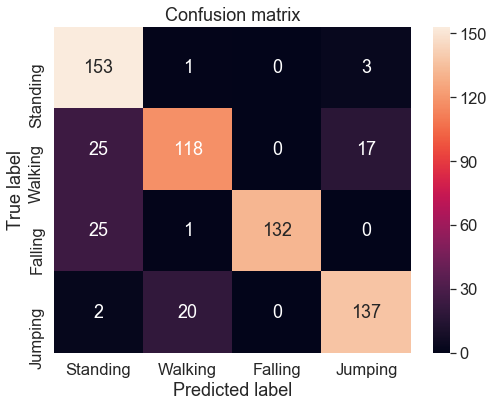

In [92]:
# use LSTM model to predict

y_pred_ohe = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)
print(y_true_labels)
LABELS = ['Standing','Walking','Falling','Jumping']

plt.figure(figsize=(8, 6))
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
# plt.ylim((16,14))
plt.xlabel('Predicted label')
plt.show();



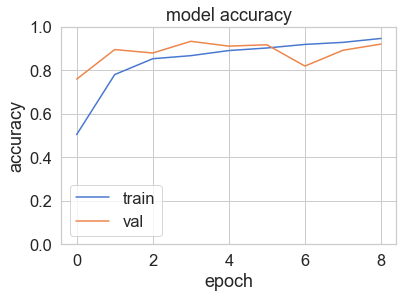

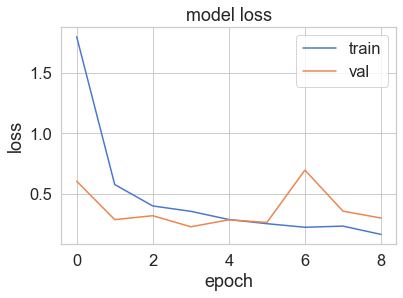

In [58]:
plt.plot(lstm.history['accuracy'])
plt.plot(lstm.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.legend(['train', 'val'], loc='best')
plt.show()

plt.plot(lstm.history['loss'])
plt.plot(lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

# Save the model into .pb file

In [21]:
# N_TIME_STEPS = 100 #sliding window length
# STEP = 20 #Sliding window step size
# N_FEATURES = 8


In [102]:
# Save LSTM model

output_node_name = "Dense_2/Softmax"
MODEL_LSTM = str(N_TIME_STEPS)+"_"+str(STEP)+"_"+str(N_FEATURES)+"_"+str(N_CLASSES)+"_nomagnew"

tf.train.write_graph(K.get_session().graph_def, './models/LSTM/', \
        MODEL_LSTM + '_graph.pbtxt')
saver = tf.train.Saver()
saver.save(K.get_session(), './models/LSTM/' + MODEL_LSTM + '.chkp')

freeze_graph.freeze_graph('./models/LSTM/' +MODEL_LSTM+ '_graph.pbtxt', None, \
    False, './models/LSTM/' + MODEL_LSTM+ '.chkp', output_node_name, \
    "save/restore_all", "save/Const:0", \
    './models/LSTM/' +MODEL_LSTM + '.pb', True, "")



INFO:tensorflow:Restoring parameters from ./models/LSTM/100_20_6_3_nomagnew.chkp
INFO:tensorflow:Froze 13 variables.
INFO:tensorflow:Converted 13 variables to const ops.


node {
  name: "LSTM_1_input"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: -1
        }
        dim {
          size: 100
        }
        dim {
          size: 6
        }
      }
    }
  }
}
node {
  name: "LSTM_1/kernel"
  op: "Const"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "value"
    value {
      tensor {
        dtype: DT_FLOAT
        tensor_shape {
          dim {
            size: 6
          }
          dim {
            size: 32
          }
        }
        tensor_content: "\252;\274\275.D\302<w\001G\276\377 H\275\221\301i\27663\247>E\265\216\274\256\343\252=\305\034{\273?\0160>xl\367\275\236\374\211>\250\313\271\275\216\033\014>N\206\377=\307D\221>\037\360\260<\334\220j\273\372\017I\275\256\345\230=\275\206\344<NG\260\276\264}\315=\240\270\001\277\340YQ=\037/\342\276.\330\345=\316\244\322\274\031\336J

# CNN Model 

In [ ]:
# from keras.backend import clear_session

# clear_session()
# # CNN model

# model = Sequential()

# model.add(Conv2D(N_HIDDEN_UNITS * 3, kernel_size = 3, input_shape = (X_train.shape[1], X_train.shape[2], 1), padding = 'same',
#                  activation = 'relu', name="Conv2D_Layer1"))
# model.add(Conv2D(N_HIDDEN_UNITS * 2, kernel_size = 3, padding = 'same', activation = 'relu', name="Conv2D_Layer2"))
# model.add(Conv2D(N_HIDDEN_UNITS, kernel_size = 3, padding = 'same', activation = 'relu', name="Conv2D_Layer3"))
# model.add(Flatten(name="Flatten_Layer"))
# model.add(Dense(N_CLASSES, activation = 'softmax', name="CNN_output"))

# model.summary()

# model.compile(optimizer='Adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# BATCH_SIZE = 24
# N_EPOCHS = 100

# cnn = model.fit(np.expand_dims(X_train, axis=-1), y_train,
#                 batch_size=BATCH_SIZE, epochs=N_EPOCHS,
#                 validation_data=(np.expand_dims(X_test, axis=-1), y_test))

In [ ]:
# model.save("model_har.h5")

In [ ]:
# y_pred_ohe = model.predict(np.expand_dims(X_test, axis=-1))
# y_pred_labels = np.argmax(y_pred_ohe, axis=1)
# y_true_labels = np.argmax(y_test, axis=1)
# confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)

# LABELS = [ 'standing', 'walking']

# plt.figure(figsize=(8, 6))
# sns.set(style='whitegrid', palette='muted', font_scale=1.5)
# sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
# plt.title("CNN Result Confusion Matrix")
# plt.ylabel('True label')
# # plt.ylim((16,14))
# plt.xlabel('Predicted label')
# plt.show();

# plt.plot(cnn.history['acc'])
# plt.plot(cnn.history['val_acc'])
# plt.title('CNN model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='best')
# plt.show()

# plt.plot(cnn.history['loss'])
# plt.plot(cnn.history['val_loss'])
# plt.title('CNN model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='best')
# plt.show()

# Save model to .pb file

In [ ]:
# # Save CNN model
# output_node_name = "CNN_output/Softmax"
# MODEL_NAME = "2020_02_09_CNN"

# tf.train.write_graph(K.get_session().graph_def, './models/CNN/', \
#         MODEL_NAME + '_graph.pbtxt')
# saver = tf.train.Saver()
# saver.save(K.get_session(), './models/CNN/' + MODEL_NAME + '.chkp')

# freeze_graph.freeze_graph('./models/CNN/' + MODEL_NAME + '_graph.pbtxt', None, \
#     False, './models/CNN/' + MODEL_NAME + '.chkp', output_node_name, \
#     "save/restore_all", "save/Const:0", \
#     './models/CNN/' + MODEL_NAME + '.pb', True, "")

# Convert .pb to tflite

In [ ]:
# import tensorflow as tf
# # model_dir='./models/CNN/2020_02_09_CNN.pb'
# model_dir='model_har.h5'

# input_arrays = ['Conv2D_Layer1_input']
# output_arrays = ['CNN_output/Softmax']

# tfc = tf.lite.TFLiteConverter.from_keras_model_file(model_dir)
# # converter =  tfc.from_keras_model_file(model_dir, input_arrays, output_arrays)

# tflite_model = tfc.convert()
# open("CNN_model.tflite","wb").write(tflite_model)

# Make sure the model output and input name

In [ ]:
# import tensorflow as tf
# gf = tf.GraphDef()   
# m_file = open(r"D:\Human Activity Recognition\Training\models\LSTM\100_12_walk_stand.pb",'rb')
# gf.ParseFromString(m_file.read())

# with open('somefile.txt', 'a') as the_file:
#     for n in gf.node:
#         the_file.write(n.name+'\n')

# file = open('somefile.txt','r')
# data = file.readlines()
# print ("output name = ")
# print (data[len(data)-1])

# print ("Input name = ")
# file.seek ( 0 )
# print (file.readline())